### Imports

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import bigrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

import re
import numpy as np
import pandas as pd
import os
from tabulate import tabulate #for pretty printing of df

import gensim
from gensim.models.phrases import Phrases, Phraser

import itertools  #used for flattening lists of lists
import math
import csv
from help_functions import test_dictionary #for quickly pretty dictionary
from help_functions import get_next_qtr #for getting next quarter given a quarter/year
import matplotlib.pyplot as plt
from collections import Counter
import time



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Steve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Stop Words, CSV Files, and Year List, SNL_Map

In [2]:
nltk_stop_words = set(stopwords.words('english'))
words_to_remove = ['below', 'haven']   #reasonable words to be meaningful
stop_words = list(filter(lambda word: word not in words_to_remove, nltk_stop_words))
print(f'stop_words: {stop_words}')

### create list of csv files and years
csv_files = [os.path.join('data', file) for file in os.listdir('data')]
years_list = list(range(2009, 2025))

### create a look up file to get ciq id and map to related snl id
seed_words = ['uncertainty','uncertain','ambiguity', 'confusion', 'unpredictable', 'unpredictability']

### import csv as dataframes for transcript/company ids and loan data/snl ids
delta_df = pd.read_csv('snldata/transcript_loans.csv', encoding='utf-8')
print()
print(tabulate(delta_df.head(), headers='keys', tablefmt='pretty'))

print('')
print(f'mapping files have been loaded in')

stop_words: ['himself', "don't", 'were', 'again', 'myself', 'the', 'didn', 'what', 'shouldn', 'i', 'a', 'don', 'mightn', 'up', 'under', 'these', 'having', "shan't", 'him', "she's", 'only', 'is', 'this', 'whom', "mightn't", 'their', 'further', 'when', 'too', 'ours', "won't", 'will', 'ain', 'have', 'own', "haven't", 'isn', 'themselves', 'down', 'had', 'yourself', "should've", 'and', 'itself', 'that', 'or', 'hasn', 'its', "hasn't", 'y', 'they', 'been', 'between', "you'll", 'll', 'same', 'out', 'mustn', 'against', "mustn't", 'for', 'm', "wasn't", 'each', 'during', 'his', 'won', 'be', 'before', 'after', 'should', 've', 'but', 'those', 'it', 'theirs', 'if', 'shan', 'here', 'now', "wouldn't", 'being', "shouldn't", 'through', 'to', 'needn', 'my', 'such', 'did', 'does', 'because', 'where', 'just', 'hadn', 'in', 'an', 'yourselves', 'until', 'am', 'our', 'off', "doesn't", 'why', "you'd", 'was', "that'll", 'we', 'into', 'there', 'can', 'd', 'any', 'ourselves', 'he', 'very', "didn't", 'as', 'your',

In [3]:
with open('snldata/soto_uncertainty_words.txt', 'r') as file:
    # Read each line and strip the newline characters
    soto_uncertainty_words = [line.strip() for line in file.readlines()]

print(f'soto uncertainty words: {soto_uncertainty_words}')

soto uncertainty words: ['adapted', 'amid', 'amidst', 'amplified', 'anxiety', 'attacks', 'austerity', 'backdrop', 'benign', 'bipartisan', 'brexit', 'ceiling', 'challenges', 'challenging', 'cliff', 'climate', 'clouded', 'commonwealth', 'concerns', 'conditions', 'confluence', 'confronting', 'congress', 'consumption', 'crash', 'crises', 'currents', 'cycles', 'deficit', 'deficits', 'deflation', 'deflationary', 'downturn', 'dysfunction', 'economic', 'election', 'elections', 'emerged', 'encountered', 'environment', 'environments', 'eu', 'euro', 'eurozone', 'face', 'faced', 'faces', 'facing', 'fears', 'fiscal', 'flash', 'fragile', 'franc', 'geo', 'geopolitical', 'governmental', 'governments', 'gridlock', 'gyrations', 'hampering', 'headwinds', 'heightened', 'illiquidity', 'immune', 'impasse', 'instability', 'intervention', 'iraq', 'lackluster', 'legislative', 'legislature', 'lingering', 'looming', 'ltro', 'macroeconomic', 'makers', 'midst', 'midterm', 'monetary', 'myriad', 'nafta', 'navigate',

## Class Definition for Object Storage

In [4]:
#create objects to store data for each year and all years combined


class Nodes:
  node_dict = {} #tracks nodes for each year

  def __init__(self, year, lem_dict, flat_lem_dict, lem_corpus, flat_lem_corpus, model=None, uncertainty_wordlist=None):

    self.year = year
    self.model = model
    self.uncertainty_wordlist = uncertainty_wordlist  #tracks final uncertainty wordlist
    self.lem_corpus = lem_corpus              #stores the cleaned corpus with bigrams for running model (list of sentences)
    self.lem_dict = lem_dict                    #dictionary storing transcript_id:list of sentences for scoring
    self.flat_lem_corpus = flat_lem_corpus    #stores flattened list of corpus bigrams for idf calculation
    self.flat_lem_dict = flat_lem_dict

    Nodes.node_dict[year] = self

#tracks combined node
class Combined_Node:

  def __init__(self, lem_dict, flat_lem_dict, lem_corpus, flat_lem_corpus, model=None, uncertainty_wordlist=None):

    self.model = model
    self.uncertainty_wordlist = uncertainty_wordlist
    self.lem_corpus = lem_corpus              #stores the cleaned corpus with bigrams for running model (list of sentences)
    self.lem_dict = lem_dict                    #dictionary storing transcript_id:list of sentences for scoring
    self.flat_lem_corpus = flat_lem_corpus
    self.flat_lem_dict = flat_lem_dict    #stores flattened list of corpus bigrams for idf calculation




## Functions

### Split Text Function

In [5]:
#take raw text and tokenize the words
def split_text_to_sentences_words(text):
    # Split into sentences
    sentences = nltk.sent_tokenize(text)

    # Split each sentence into a list of words
    sentences_words = [nltk.word_tokenize(sentence) for sentence in sentences]

    return sentences_words

#grab pos for lemmatizing
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    elif treebank_tag.startswith('J'):
        return wordnet.ADJ
    else:
        return wordnet.NOUN  # Default to noun

### Get Corpus

In [6]:
#takes single csv file and returns dictionary transcipt_id: [[word, word, word],[word, word, word]]
def get_corpus(csv_file):
   df = pd.read_csv(csv_file, encoding='utf-8')
   df['COMPONENTTEXT_SPLIT'] = df['COMPONENTTEXT'].apply(split_text_to_sentences_words) #splits data in pandas cell into list of sentences

   unprocessed_dict = {}
   for row in df.itertuples():
      if row.TRANSCRIPTID not in unprocessed_dict:
         unprocessed_dict[row.TRANSCRIPTID] = row.COMPONENTTEXT_SPLIT
      else:
         unprocessed_dict[row.TRANSCRIPTID].extend(row.COMPONENTTEXT_SPLIT)
   return unprocessed_dict


### Process Dict

In [7]:
#takes unprocessed dict and returns processed dict (lowercase, lemmatize with pos, remove punct, leave hyphens)

def clean(tokenized_dict):
   num_tokens_before = 0
   num_tokens_after = 0
   punct_removed_dict = {}

   for transcriptid, text in tokenized_dict.items():
      p_text = []
      for sentence in text:
         p_sentence = []
         for word in sentence:
            num_tokens_before += 1
            p_word = word.lower()                                  #lowercase the text
            p_word = re.sub(r'(?<!\w)-(?!\w)|[^\w\s-]', '', p_word) #remove punctuation but keep hyphens
            if len(p_word) > 0:
               p_sentence.append(p_word)
         p_text.append(p_sentence)
         num_tokens_after += len(p_text)
      punct_removed_dict[transcriptid] = p_text
   return punct_removed_dict, num_tokens_before, num_tokens_after

def create_bigrams_pre_lem(punct_removed_dict, min_count=10, threshold = 100):
   flat_pr_corpus = [item for sublist in punct_removed_dict.values() for item in sublist]

   phrases = Phrases(flat_pr_corpus, min_count, threshold, scoring='default')
   bigram_phraser = Phraser(phrases)

   num_tokens = 0
   bigram_dict = {}

   for transcript_id, text in punct_removed_dict.items():
      bigram_text = [bigram_phraser[sentence] for sentence in text] #creates a list of list with bigrams included
      bigram_dict[transcript_id] = bigram_text
      num_tokens += sum(len(sublist) for sublist  in bigram_text)

   return phrases, bigram_phraser, bigram_dict, num_tokens

def process_the_data_lemmatizer(bigram_dict, stop_words):
   num_tokens_after = 0
   lem_dict = {}
   flat_lem_dict = {}
   lem_corpus = []
   flat_lem_corpus = []

   lemmatizer = WordNetLemmatizer()

   for transcriptid, text in bigram_dict.items():
      p_text = []
      flat_list = []
      for sentence in text:
         lemmatized_sentence = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in sentence if word not in stop_words]
         # print(f'ls: {lemmatized_sentence}')
         p_text.append(lemmatized_sentence)
         flat_list.extend(lemmatized_sentence)
         lem_corpus.append(lemmatized_sentence)
         flat_lem_corpus.extend(lemmatized_sentence)

      num_tokens_after += len(flat_list)
      lem_dict[transcriptid] = p_text
      flat_lem_dict[transcriptid] = flat_list

   return lem_dict, flat_lem_dict, lem_corpus, flat_lem_corpus


# def process_the_data_lemmatizer(unprocessed_dict, stop_words):
#    num_tokens_before = 0
#    num_tokens_after = 0
#    processed_dict = {}

#    lemmatizer = WordNetLemmatizer()

#    for transcriptid, text in unprocessed_dict.items():
#       p_text = []
#       for sentence in text:
#          p_sentence = []
#          for word in sentence:
#             num_tokens_before += 1
#             p_word = word.lower()                                  #lowercase the text
#             p_word = re.sub(r'(?<!\w)-(?!\w)|[^\w\s-]', '', p_word)
#             p_sentence.append(p_word)  #remove punctuation but keep hyphens

#          lemmatized_sentence = [lemmatizer.lemmatize(word, get_wordnet_pos(word))
#                                  for word in p_sentence if word not in stop_words and len(word) > 0]

#          p_text.append(lemmatized_sentence)
#          num_tokens_after += len(lemmatized_sentence)
#       processed_dict[transcriptid] = p_text
#    return processed_dict


# #below does not use lemmatizer. much faster.
# def process_the_data(unprocessed_dict, stop_words):
#    num_tokens_before = 0
#    num_tokens_after = 0
#    processed_dict = {}

#    for transcriptid, text in unprocessed_dict.items():
#       p_text = []
#       for sentence in text:
#          p_sentence = []
#          for word in sentence:
#             num_tokens_before += 1
#             p_word = word.lower()                                  #lowercase the text
#             p_word = re.sub(r'(?<!\w)-(?!\w)|[^\w\s-]', '', p_word)  #remove punctuation but keep hyphens
#             if p_word in stop_words or len(p_word) == 0:             #ignore if word has no length (ie was punctuation only) or in stop words
#                continue
#             p_sentence.append(p_word)
#          p_text.append(p_sentence)
#          num_tokens_after += len(p_sentence)
#       processed_dict[transcriptid] = p_text
#    print(f'tokens before:{num_tokens_before} | tokens after:{num_tokens_after}')
#    return processed_dict



### Create Bigrams

In [8]:
# """
# below function returns:
#     lem_corpus: list of sentences for full corpus to run through word2vec
#     dict_bigrams: links transcript id to corpus for uncertainty calc
#     flat_lem_corpus: flat version of corpus bigrams for counting word appearances easily
# """

# def create_bigrams(processed_dict, min_count=10, threshold = 100):
#    processed_corpus = []
#    for value in processed_dict.values():
#       processed_corpus.extend(value)

#    phrases = Phrases(processed_corpus, min_count, threshold, scoring='default')
#    bigram_phraser = Phraser(phrases)

#    lem_corpus = []

#    dict_bigrams = {}
#    for transcript_id, text in processed_dict.items():
#       bigram_text = [bigram_phraser[sentence] for sentence in text]
#       dict_bigrams[transcript_id] = bigram_text
#       lem_corpus.extend(bigram_text)


#    flat_lem_corpus = [item for sublist in lem_corpus for item in sublist]  #flatten list

#    # print('bigrams created')
#    return phrases, bigram_phraser, lem_corpus, dict_bigrams, flat_lem_corpus


### Create IDF dictionary

In [9]:
#create idf dictionary upon node creation by looking at uncertainty word list
def create_idf_dict(node):
    idf_dict = {}
    n = len(node.lem_dict) #number of transcripts
    for word in node.uncertainty_wordlist:
        t = 0
        for transcript_id, transcript_text in node.flat_lem_dict.items():
            if word in transcript_text:
                t+=1   #count if word appears in transcript

        idf= math.log2(n/t)
        idf_dict[word] = idf
    return idf_dict


#seperate run to create an idf dict for soto uncertainty words
def create_idf_dict_soto_wordlist(node, soto_uncertainty_words):
    idf_dict = {}
    n = len(node.lem_dict)
    for word in soto_uncertainty_words:
        t = 1          #initialize at 1 so you don't divide by 0 if word never appears
        for transcript_id, transcript_text in node.flat_lem_dict.items():
            if word in transcript_text:
                t+=1

        idf= math.log2(n/t)
        idf_dict[word] = idf

    return idf_dict



### Build uncertainty words

In [10]:
#uses a list of seed words and collects top n words by proximity score

def build_uncertainty_words(node, trained_model, seed_words, delta_df, return_number = 100):
    result_dictionary = {}
    for seed_word in seed_words:
        try:
            similar_words = trained_model.wv.most_similar(seed_word, topn=300)
        except KeyError:
            continue
        for word, number in similar_words:
            if word not in result_dictionary:
                result_dictionary[word] = number
            else:
                result_dictionary[word] = max(number, result_dictionary[word])

    ordered_words = sorted(result_dictionary, key=result_dictionary.get, reverse=True)     # orders word list by score
    final_list = []                                                                        # checks that the word appears in at least two different companies
    while len(final_list) < return_number:
        for word in ordered_words:
            ciq_id_count = transcript_lookup(word, node.flat_lem_dict, delta_df)
            if ciq_id_count < 2:
                continue
            else: final_list.append(word)
            if len(final_list) == return_number:
                break

    return final_list


### Calculate Uncertainty scores - regular and soto variant

In [11]:

#calculates uncertainty in a node by counting uncertainty words and dividing by bigram transcript length. Adds score to dataframe.
def calc_uncertainty_reg(node, delta_df, column_name):
    for transcript_id, transcript_text in node.flat_lem_dict.items():
        uncty_cnt = 0
        for word in transcript_text:
            if word in node.uncertainty_wordlist:
                uncty_cnt += 1
        uncty_score = uncty_cnt/len(transcript_text)
        try:
            delta_df.loc[delta_df['transcript_id'] == transcript_id, column_name] = uncty_score
        except KeyError:
            continue

#calculates uncertainty in a node by counting uncertainty words if they appear, weighing by tf_idf, and dividing by number of words in transcript
def calc_uncertainty_soto(node, delta_df, column_name):
    for transcript_id, transcript_text in node.flat_lem_dict.items():
        word_count_dict = Counter(transcript_text)    #creates a count dictionary for each word in transcript
        d = len(transcript_text)
        tf_idf_sum = 0
        for word in node.uncertainty_wordlist:
            if word in transcript_text:
                t = word_count_dict[word]
                tf = t/d
                idf = node.idf_dict[word]
                # print(f'word:{word}| t:{t}|d:{d}|tf:{tf}|idf:{idf}')
                tf_idf = tf*idf
                tf_idf_sum += tf_idf

        uncty_score = tf_idf_sum/len(set(transcript_text))
        # print(f'tf_idf_sum: {tf_idf_sum}| transcript length: {len(set(transcript_text))}|uncty_score:{uncty_score}')

        try:
            delta_df.loc[delta_df['transcript_id'] == transcript_id, column_name] = uncty_score #some transcripts missing if there wasn't any financial data
            # print(uncty_score)
        except KeyError:
            # print(f'{transcript_id}: key error')
            continue

#calculates soto uncertainty using soto method
def calc_uncertainty_soto_wordlist(node, delta_df, column_name, soto_uncertainty_words):
    for transcript_id, transcript_text in node.flat_lem_dict.items():
        word_count_dict = Counter(transcript_text)
        d = len(transcript_text)
        tf_idf_sum = 0
        for word in soto_uncertainty_words:
            if word in transcript_text:
                t = word_count_dict[word]
                tf = t/d
                idf = node.idf_dict_full[word]
                # print(f'word:{word}| t:{t}|d:{d}|tf:{tf}|idf:{idf}')
                tf_idf = tf*idf
                tf_idf_sum += tf_idf

        uncty_score = tf_idf_sum/len(set(transcript_text))
        # print(f'tf_idf_sum: {tf_idf_sum}| transcript length: {len(set(transcript_text))}|uncty_score:{uncty_score}')

        try:
            delta_df.loc[delta_df['transcript_id'] == transcript_id, column_name] = uncty_score
            # print(uncty_score)
        except KeyError:
            # print(f'{transcript_id}: key error')
            continue



### Extend yearly corpus to full corpus

In [12]:
#helper functuon that takes each year and combines dictionaries to create one complete node
def extend_to_full(model_node_dict):
    lem_corpus_allyrs = []
    flat_lem_corpus_allyrs = []
    lem_dict_allyrs = {}
    flat_lem_dict_allyrs = {}

    for year, node in model_node_dict.items():
        lem_corpus_allyrs.extend(node.lem_corpus)
        flat_lem_corpus_allyrs.extend(node.flat_lem_corpus)
        lem_dict_allyrs.update(node.lem_dict)
        flat_lem_dict_allyrs.update(node.flat_lem_dict)

    return lem_corpus_allyrs,flat_lem_corpus_allyrs,lem_dict_allyrs, flat_lem_dict_allyrs


### Lookup word and year to see which which transcripts contain it

In [13]:
def company_quarter_lookup(transcript_id, delta_df):

    try:
        ciq_id = delta_df.loc[delta_df['transcript_id'] == transcript_id, 'ciq_id'].values[0]
        quarter = delta_df.loc[delta_df['transcript_id'] == transcript_id, 'quarter'].values[0]
    except IndexError:
        ciq_id = 11111
        quarter = 'NA'
    return(ciq_id,quarter)


def transcript_lookup(word, dict, delta_df):
    count_set = set()
    for transcript_id, flat_list in dict.items():
        if word in flat_list:
            # print(word, transcript_id)
            ciq_id, quarter = company_quarter_lookup(transcript_id, delta_df)
            count_set.add(ciq_id)
        if len(count_set) == 2:
            break
    return len(count_set)


def transcript_lookup_print(word, dict, delta_df):
    for transcript_id, flat_list in dict.items():
        count_set = set()
        if word in flat_list:
            ciq_id, quarter = company_quarter_lookup(transcript_id, delta_df)
            print(transcript_id, ciq_id, quarter)

### Word2Vec Model

In [14]:

def apply_word2vec(lem_corpus, v_size=300, w = 10, mc = 10, e = 10):
   model = gensim.models.Word2Vec (
    vector_size=v_size,    # Number of features in word vector

    window=w,   # Context window size (in each direction). Default is 5


    min_count=mc, # Words must appear this many times to be in vocab.
                 #   Default is 5

    workers=10,  # Training thread count

    sg=1,        # 0: CBOW, 1: Skip-gram.

    hs=0,        # 0: Negative Sampling, 1: Hierarchical Softmax
                 #   Default is 0, NS

    negative=5   # Nmber of negative samples
                 #   Default is 5
   )

   model.build_vocab(
    lem_corpus
   )

   model.train(
    lem_corpus,
    total_examples=len(lem_corpus),
    epochs=e        # How many training passes to take.
   )

   return(model)

## Run Models

### Process the data

In [15]:
#Process Data

num_tokens_b = 0
num_tokens_a = 0
num_tokens_ab = 0
start_time = time.time()

for index, file in enumerate(csv_files):
    tokenized_dict = get_corpus(file)
    punct_removed_dict, num_tokens_before, num_tokens_after = clean(tokenized_dict)
    phrases, bigram_phraser, bigram_dict, num_tokens_after_bigrams = create_bigrams_pre_lem(punct_removed_dict, min_count=10, threshold = 100)
    lem_dict, flat_lem_dict, lem_corpus, flat_lem_corpus =  process_the_data_lemmatizer(bigram_dict, stop_words)
    Nodes(years_list[index], lem_dict, flat_lem_dict, lem_corpus, flat_lem_corpus)

    num_tokens_b += num_tokens_before
    num_tokens_a += num_tokens_after
    num_tokens_ab += num_tokens_after_bigrams

end_time = time.time()
print(f"Time taken for processing years: {end_time - start_time:.0f} seconds")
print()

start_time = time.time()
lem_corpus_allyrs,flat_lem_corpus_allyrs,lem_dict_allyrs, flat_lem_dict_allyrs = extend_to_full(Nodes.node_dict)
full_node = Combined_Node(lem_corpus=lem_corpus_allyrs, flat_lem_dict = flat_lem_dict_allyrs, lem_dict = lem_dict_allyrs, flat_lem_corpus = flat_lem_corpus_allyrs)
end_time = time.time()
print(f"Time taken for extending years: {end_time - start_time:.0f} seconds")

print()
print(f'Starting tokens: {num_tokens_b}')
print(f'Tokens after cleaning: {num_tokens_a}')
print(f'Tokens after bigrams: {num_tokens_ab}')
print(f'Tokens after full processing: {len(flat_lem_corpus_allyrs)}')


Time taken for processing years: 1086 seconds

Time taken for extending years: 5 seconds

Starting tokens: 6425880
Tokens after cleaning: 66398358
Tokens after bigrams: 5639208
Tokens after full processing: 28929243


### Train the Models

In [53]:
#Train Models

#yearly corupus
model_time = 0
wl_time = 0
idf_time = 0

for year, node in Nodes.node_dict.items():

    start_time
    trained_model = apply_word2vec(node.lem_corpus, e = 20)
    end_time = time.time()
    model_time += end_time - start_time


    start_time = time.time()
    word_list = build_uncertainty_words( node,trained_model, seed_words, delta_df, 100)
    end_time = time.time()
    wl_time += end_time - start_time


    node.model=trained_model
    node.uncertainty_wordlist=word_list

    start_time = time.time()
    idf_dict = create_idf_dict(node)
    end_time = time.time()
    idf_time += end_time - start_time

    node.idf_dict = idf_dict

print(f"Time taken for model creation: {model_time} seconds")
print(f"Time taken for getting word lists: {wl_time} seconds")
print(f"Time taken for creating idf: {idf_time} seconds")

#full corpus
# start_time = time.time()
# trained_model = apply_word2vec(full_node.lem_corpus)
# end_time = time.time()
# print(f"Time taken for full node model creation: {end_time - start_time:.4f} seconds")

# word_list = build_uncertainty_words(full_node, trained_model, seed_words, delta_df, 150)


# full_node.model=trained_model
# full_node.uncertainty_wordlist=word_list
# start_time = time.time()
# idf_dict = create_idf_dict(full_node)
# end_time = time.time()
# print(f"Time taken for full node idf creation {year}: {end_time - start_time:.4f} seconds")

# full_node.idf_dict = idf_dict



Time taken for model creation: 280720.82005262375 seconds
Time taken for getting word lists: 24.604700803756714 seconds
Time taken for creating idf: 93.6619279384613 seconds


In [54]:
start_time = time.time()
trained_model = apply_word2vec(full_node.lem_corpus, e=20)
end_time = time.time()
print(f"Time taken for full node model creation: {end_time - start_time:.4f} seconds")

start_time = time.time()
word_list = build_uncertainty_words(full_node, trained_model, seed_words, delta_df, 150)
end_time = time.time()
print(f"Time taken for to build uncertainty word list: {end_time - start_time:.4f} seconds")

full_node.model=trained_model
full_node.uncertainty_wordlist=word_list
start_time = time.time()
idf_dict = create_idf_dict(full_node)
end_time = time.time()
print(f"Time taken for full node idf creation {year}: {end_time - start_time:.4f} seconds")

full_node.idf_dict = idf_dict


Time taken for full node model creation: 1894.7949 seconds
Time taken for to build uncertainty word list: 18.5009 seconds
Time taken for full node idf creation 2024: 145.5795 seconds


### Count Bigrams and Tokens

In [55]:
bigram_count = 0
unique_bigrams = set()
unique_tokens = set()

# Loop through the list and check for underscores
for token in full_node.flat_lem_corpus:
    unique_tokens.add(token)
    if "_" in token:
        bigram_count += 1
        unique_bigrams.add(token)

print(f'Total Tokens: {len(full_node.flat_lem_corpus)}')
print(f'Unique Tokens: {len(unique_tokens)}')
print(f'Total Bigrams: {bigram_count}')
print(f'Unique Bigrams: {len(unique_bigrams)}')


Total Tokens: 28929243
Unique Tokens: 77415
Total Bigrams: 682234
Unique Bigrams: 2289


In [19]:


# idf_dict_full = create_idf_dict_soto_wordlist(full_node, soto_uncertainty_words)
# full_node.idf_dict_full = idf_dict_full

## Calc Uncertainty Scores

In [20]:
#recreates idf_dicts with up-to-date uncertainty wordlists

# for year, node in Nodes.node_dict.items():
#     idf_dict = create_idf_dict(node)
#     node.idf_dict = idf_dict

# full_node.idf_dict = create_idf_dict(full_node)

In [56]:
#calculate all the different uncertainty scores and add to dataframe

for year, node in Nodes.node_dict.items():
    calc_uncertainty_reg(node, delta_df, 'yearnode_uncty_reg')


calc_uncertainty_reg(full_node, delta_df, 'fullnode_uncty_reg')

for year, node in Nodes.node_dict.items():
    calc_uncertainty_soto(node, delta_df, 'yearnode_uncty_soto')


calc_uncertainty_soto(full_node, delta_df, 'fullnode_uncty_soto')

print(tabulate(delta_df.head(), headers='keys', tablefmt='pretty'))

# calc_uncertainty_soto_wordlist(full_node, delta_df, 'fullnode_uncty_soto_wl', soto_uncertainty_words)

+---+---------------+------------+-----------+---------+--------+--------------------+-------------------+-------------+------------+--------------+-----------+-----------------------+----------------------+------------------------+------------------------+
|   | transcript_id |   ciq_id   |  snl_id   | quarter |  year  | total_asset_before | total_asset_after | loan_before | loan_after |  l2a_delta   | loan_diff |  yearnode_uncty_reg   |  fullnode_uncty_reg  |  yearnode_uncty_soto   |  fullnode_uncty_soto   |
+---+---------------+------------+-----------+---------+--------+--------------------+-------------------+-------------+------------+--------------+-----------+-----------------------+----------------------+------------------------+------------------------+
| 0 |   1790209.0   | 13314302.0 | 4055785.0 | Q4 2019 | 2019.0 |     12269288.0     |    12159919.0     | 10240434.0  | 10500284.0 | 0.028876319  | 259850.0  | 0.006264236902050114  | 0.008542141230068337 | 4.143779305357549e

## Print Word Lists

In [60]:
combined_uncertainty_wordlist = []   #creates a list of all uncertainty words by year

for year in years_list:
    for uncertainty_word in Nodes.node_dict[year].uncertainty_wordlist:
        if uncertainty_word not in combined_uncertainty_wordlist:
            combined_uncertainty_wordlist.append(uncertainty_word)

print(len(combined_uncertainty_wordlist))

787


In [62]:
## count total instances of word
word_freq_df = pd.DataFrame(index=years_list, columns=combined_uncertainty_wordlist)

for year in years_list:
    word_counts = Counter((Nodes.node_dict[year].flat_lem_corpus))
    for uncertainty_word in combined_uncertainty_wordlist:
        count = word_counts[uncertainty_word]
        word_freq_df.at[year, uncertainty_word] = count

In [71]:
for year in years_list:
    print(year)
    count = 0

    for word in Nodes.node_dict[year].uncertainty_wordlist:
        average_count = word_freq_df[word].mean()
        year_count = word_freq_df.at[year, word]

        if year_count/average_count > 3:
            count += 1
    print(count)

2009
11
2010
9
2011
12
2012
13
2013
4
2014
1
2015
3
2016
3
2017
3
2018
9
2019
12
2020
29
2021
15
2022
17
2023
11
2024
5


### Yearly Word List

In [63]:
export_df = pd.DataFrame()

for year in years_list:
    # print(year)
    word_series = []
    for word in Nodes.node_dict[year].uncertainty_wordlist:
        average_count = word_freq_df[word].mean()
        year_count = word_freq_df.at[year, word]
        # if year_count/average_count > 0:
        word_series.append((year_count/average_count,word))
        sorted_pairs = sorted(word_series, reverse=True)
        sorted_values, sorted_words = zip(*sorted_pairs)
        sorted_words = list(sorted_words)

    export_df[year] = pd.Series(sorted_words)

            # print(f"{word} | {year_count}")

export_df.fillna('', inplace=True)
print(tabulate(export_df, headers='keys', tablefmt='pretty'))


+----+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+----------------------------+--------------------------+--------------------------+--------------------------+--------------------------+----------------------------+
|    |            2009            |            2010            |            2011            |            2012            |            2013            |            2014            |            2015            |            2016            |            2017            |            2018            |            2019            |           2020           |           2021           |           2022           |           2023           |            2024            |
+----+----------------------------+----------------------------+----------

In [25]:
# export_df.to_csv('yearly_word_run4.csv')

### Transcript Look Up

In [76]:
transcript_lookup_print('fas_91', Nodes.node_dict[2014].flat_lem_dict, delta_df)

672245 2674024.0 Q2 2014
569263 362889.0 Q4 2013
611278 19049.0 Q1 2014
658533 19049.0 Q2 2014
704006 19049.0 Q3 2014
1759032 19049.0 Q4 2013
568757 9870193.0 Q4 2013
612328 9870193.0 Q1 2014
661974 26840554.0 Q2 2014
571591 393970.0 Q4 2013
659255 303685.0 Q2 2014
615879 667035.0 Q1 2014
569042 108443.0 Q4 2013


In [82]:
for word in Nodes.node_dict[2014].flat_lem_dict[568757]:
    if word in Nodes.node_dict[2014].uncertainty_wordlist:
        print(word)

forward-looking_statements
form_10-k
sec
suffered
fas_91
quarter-to-quarter
factor
cause


In [87]:
try:
    name = delta_df.loc[delta_df['transcript_id'] == 568757, 'l2a_delta'].iloc[0]
    print(f"The name for primary_key {key} is {name}")
except IndexError:
    print(f"Primary key {key} not found in the DataFrame.")

name = delta_df.loc[delta_df['transcript_id'] == 2925824, 'l2a_delta'].iloc[0]
print(f"The name for primary_key {key} is {name}")


The name for primary_key (300, 10, 10, 20) is -0.008747971
The name for primary_key (300, 10, 10, 20) is -0.020855329


### Full Corpus Word List

In [64]:
word_counts = Counter(full_node.flat_lem_corpus)
for uncertainty_word in full_node.uncertainty_wordlist:
        count = word_counts[uncertainty_word]
        print(f"{uncertainty_word} | {count}")

unknown | 815
challenging | 5411
volatile | 2081
geopolitical | 312
difficult | 7372
lumpy | 1632
subject | 6704
navigate | 943
uncertain | 1847
uncertainty | 11822
choppy | 315
unpredictable | 260
bumpy | 135
unclear | 217
predict | 4390
fragile | 94
cautious | 3469
vary_materially | 64
differ_materially | 5832
factor | 21770
volatility | 5680
economic | 20612
cause_actual | 3334
noise | 2406
concern | 4543
turbulent | 131
involve_risks | 695
onerous | 59
swirling | 10
unchartered | 15
surrounding | 586
environment | 37906
geopolitical_tensions | 11
circumspect | 27
risk | 36371
intrusion | 10
unknown_risks | 261
fate | 10
postponement | 14
actual_results | 169
unusual | 3320
prudent | 3851
clarity | 2150
unprecedented | 690
lack | 1781
quarter-to-quarter | 3510
fluid | 351
uneven | 274
inherently | 320
caution | 1914
unpredictability | 35
unanswered | 15
chaotic | 10
ignorance | 13
tenuous | 13
challenge | 7874
uncertainty_surrounding | 47
unexpected | 756
historical_facts | 340
prov

In [65]:
# compare soto list vs my uncertainty list



common_words = set(soto_uncertainty_words) & set(full_node.uncertainty_wordlist)
for word in common_words:
    print(word)
print('-----')
print('Just in soto')
print('-----')
difference_list1 = list(set(soto_uncertainty_words) - set(full_node.uncertainty_wordlist))
for word in difference_list1:
    print(word)
print('-----')
print('Just in mine')
print('-----')
difference_list2 = list(set(full_node.uncertainty_wordlist) - set(soto_uncertainty_words))
for word in difference_list2:
    print(word)



unprecedented
dysfunction
climate
uneven
prolonged
challenging
stressful
macroeconomic
geopolitical
uncertainty
uncertain
fragile
austerity
gridlock
paralysis
turbulent
navigate
backdrop
economic
unrest
surrounding
unsettled
environment
instability
-----
Just in soto
-----
confluence
referendum
political
midst
election
anxiety
attacks
persistently
terrorist
concerns
persistent
adapted
intervention
eu
deficit
lackluster
bipartisan
peso
nafta
commonwealth
impasse
swiss
deflation
reactions
emerged
congress
war
ripple
midterm
immune
confronting
tensions
consumption
prevailed
threat
stimulus
eurozone
illiquidity
gyrations
deficits
ltro
navigating
benign
sparked
brexit
tariffs
withstand
protracted
face
encountered
elections
tsunami
looming
persisted
headwinds
turbulence
tumultuous
rhetoric
posed
governmental
sluggish
weathering
society
currents
reforms
persist
iraq
recessionary
franc
sequester
upheaval
shutdown
cycles
lingering
stimulative
faced
fiscal
psychology
tariff
threats
amid
amidst
p

## Scatter Plots

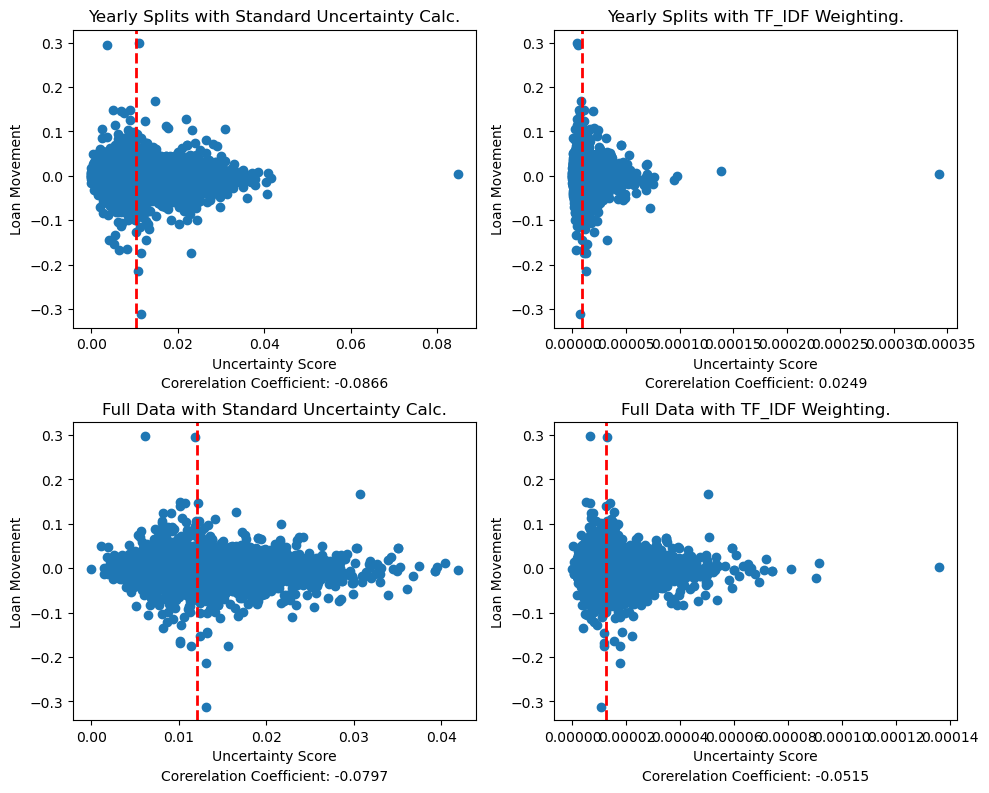

In [66]:
# Scatter plot of uncertainty score vs loan movement
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

mean_value = delta_df['yearnode_uncty_reg'].mean()
correlation = delta_df['yearnode_uncty_reg'].corr(delta_df['l2a_delta'])
axs[0,0].scatter( delta_df['yearnode_uncty_reg'],delta_df['l2a_delta'])
axs[0,0].set_xlabel('Uncertainty Score')
axs[0,0].set_ylabel('Loan Movement')
axs[0,0].set_title('Yearly Splits with Standard Uncertainty Calc.')
axs[0,0].text(0.5, -0.2, 'Corerelation Coefficient: '+str(round(correlation, 4)), ha='center', transform=axs[0, 0].transAxes)
axs[0,0].axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')

mean_value = delta_df['yearnode_uncty_soto'].mean()
correlation = delta_df['yearnode_uncty_soto'].corr(delta_df['l2a_delta'])
axs[0,1].scatter( delta_df['yearnode_uncty_soto'],delta_df['l2a_delta'])
axs[0,1].set_xlabel('Uncertainty Score')
axs[0,1].set_ylabel('Loan Movement')
axs[0,1].set_title('Yearly Splits with TF_IDF Weighting.')
axs[0,1].text(0.5, -0.2, 'Corerelation Coefficient: '+str(round(correlation, 4)), ha='center', transform=axs[0, 1].transAxes)
axs[0,1].axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')

mean_value = delta_df['fullnode_uncty_reg'].mean()
correlation = delta_df['fullnode_uncty_reg'].corr(delta_df['l2a_delta'])
axs[1,0].scatter( delta_df['fullnode_uncty_reg'],delta_df['l2a_delta'])
axs[1,0].set_xlabel('Uncertainty Score')
axs[1,0].set_ylabel('Loan Movement')
axs[1,0].set_title('Full Data with Standard Uncertainty Calc.')
axs[1,0].text(0.5, -0.2, 'Corerelation Coefficient: '+str(round(correlation, 4)), ha='center', transform=axs[1, 0].transAxes)
axs[1,0].axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')

mean_value = delta_df['fullnode_uncty_soto'].mean()
correlation = delta_df['fullnode_uncty_soto'].corr(delta_df['l2a_delta'])
axs[1,1].scatter( delta_df['fullnode_uncty_soto'],delta_df['l2a_delta'])
axs[1,1].set_xlabel('Uncertainty Score')
axs[1,1].set_ylabel('Loan Movement')
axs[1,1].set_title('Full Data with TF_IDF Weighting.')
axs[1,1].text(0.5, -0.2, 'Corerelation Coefficient: '+str(round(correlation, 4)), ha='center', transform=axs[1, 1].transAxes)
axs[1,1].axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')

plt.tight_layout()
plt.show()

In [30]:
# mean_value = delta_df['fullnode_uncty_soto_wl'].mean()
# correlation = delta_df['fullnode_uncty_soto_wl'].corr(delta_df['l2a_delta'])
# plt.scatter( delta_df['fullnode_uncty_soto_wl'],delta_df['l2a_delta'])
# plt.xlabel('Uncertainty Score')
# plt.ylabel('Loan Movement')
# plt.title('Soto Word List with TF-IDF Weighting')
# plt.text(0.5, -0.2, 'Corerelation Coefficient: '+str(round(correlation, 4)), ha='center', transform=plt.gca().transAxes)
# plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
# plt.show()


In [67]:
negative_count = (delta_df['loan_diff'] < 0).sum()
total = len(delta_df)

print(negative_count)
print(negative_count/total)
print(len(delta_df))
print((delta_df['l2a_delta'] < 0).sum())
print((delta_df['l2a_delta']).mean())
print((delta_df['l2a_delta']).var())
print(delta_df['l2a_delta'].abs().var())

2367
0.29146656815663097
8121
3782
1.1268100504988244e-05
0.0004920126113632602
0.0002855916722567654


In [32]:
top_10_rows = delta_df.nlargest(10, 'yearnode_uncty_soto')
print(tabulate(top_10_rows.sort_values(by='yearnode_uncty_soto', ascending=False), headers='keys', tablefmt='pretty'))


+------+---------------+-------------+-----------+---------+--------+--------------------+-------------------+-------------+------------+--------------+-----------+----------------------+-----------------------+------------------------+------------------------+
|      | transcript_id |   ciq_id    |  snl_id   | quarter |  year  | total_asset_before | total_asset_after | loan_before | loan_after |  l2a_delta   | loan_diff |  yearnode_uncty_reg  |  fullnode_uncty_reg   |  yearnode_uncty_soto   |  fullnode_uncty_soto   |
+------+---------------+-------------+-----------+---------+--------+--------------------+-------------------+-------------+------------+--------------+-----------+----------------------+-----------------------+------------------------+------------------------+
| 1322 |   805134.0    |  885561.0   | 4044758.0 | Q1 2015 | 2015.0 |     1443369.0      |     1439738.0     |  1165214.0  | 1167477.0  | 0.003607782  |  2263.0   | 0.047337278106508875 | 0.013806706114398421  | 0.

## Repeat Run

In [43]:
# (v_size=300, w = 10, mc = 10, e = 10)

hyperparameters = [(150, 10, 10, 10), (300, 10, 10, 10), (400, 10, 10, 10), (500, 10, 10, 10),
    (300, 5, 10, 10), (300, 10, 10, 10), (300, 15, 10, 10), (300, 20, 10, 10),
    (300, 10, 5, 10), (300, 10, 10, 10), (300, 10, 15, 10), (300, 10, 20, 10),
    (300, 10, 10, 5), (300, 10, 10, 10), (300, 10, 10, 15), (300, 10, 10, 20)]



In [49]:
def repeat_run(node_dict, hyperparameters, delta_df, seed_words):
    tracker_dict = {}

    for param_set in hyperparameters:
        feature_size = param_set[0]
        context_window = param_set[1]
        min_count = param_set[2]
        epochs = param_set[3]

        for year, node in node_dict.items():
            trained_model = apply_word2vec(node.lem_corpus, v_size=feature_size, w = context_window, mc = min_count, e = epochs)
            word_list = build_uncertainty_words( node,trained_model, seed_words, delta_df, 100)

            node.model=trained_model
            node.uncertainty_wordlist=word_list

            idf_dict = create_idf_dict(node)
            node.idf_dict = idf_dict

        trained_model = apply_word2vec(full_node.lem_corpus, v_size=feature_size, w = context_window, mc = min_count, e = epochs)
        word_list = build_uncertainty_words(full_node, trained_model, seed_words, delta_df, 150)

        full_node.model=trained_model
        full_node.uncertainty_wordlist=word_list
        idf_dict = create_idf_dict(full_node)
        full_node.idf_dict = idf_dict

        for year, node in node_dict.items():
            calc_uncertainty_reg(node, delta_df, 'yearnode_uncty_reg')
        calc_uncertainty_reg(full_node, delta_df, 'fullnode_uncty_reg')
        for year, node in node_dict.items():
            calc_uncertainty_soto(node, delta_df, 'yearnode_uncty_soto')
        calc_uncertainty_soto(full_node, delta_df, 'fullnode_uncty_soto')

        yearnode_uncty_reg = delta_df['yearnode_uncty_reg'].corr(delta_df['l2a_delta'])
        fullnode_uncty_reg = delta_df['fullnode_uncty_reg'].corr(delta_df['l2a_delta'])
        yearnode_uncty_soto = delta_df['yearnode_uncty_soto'].corr(delta_df['l2a_delta'])
        fullnode_uncty_soto = delta_df['fullnode_uncty_soto'].corr(delta_df['l2a_delta'])

        combined_yearly_uncertainty_wordlist = set()
        for key in node_dict.keys():
            for word in node_dict[key].uncertainty_wordlist:
                combined_yearly_uncertainty_wordlist.add(word)
        unique_word_count = len(combined_yearly_uncertainty_wordlist)


        word_freq_df = pd.DataFrame(index=list(node_dict.keys()), columns=list(combined_yearly_uncertainty_wordlist))

        for key in node_dict.keys():
            word_counts = Counter(node_dict[key].flat_lem_corpus)
            for uncertainty_word in combined_yearly_uncertainty_wordlist:
                count = word_counts[uncertainty_word]
                word_freq_df.at[key, uncertainty_word] = count


        rare_words = []
        for key in node_dict.keys():
            for word in node_dict[key].uncertainty_wordlist:
                average_count = word_freq_df[word].mean()
                year_count = word_freq_df.at[key, word]
                if year_count/average_count > 3:
                    rare_words.append(word)

        average_rare_words = len(rare_words)/len(node_dict)

        common_words_count = len(set(soto_uncertainty_words) & set(full_node.uncertainty_wordlist))

        correlation_calcs = [yearnode_uncty_reg, fullnode_uncty_reg, yearnode_uncty_soto, fullnode_uncty_soto]

        tracker_dict[param_set]= [unique_word_count, average_rare_words, common_words_count, correlation_calcs,full_node.uncertainty_wordlist]

    return tracker_dict














In [105]:
tracker_dict = repeat_run(Nodes.node_dict, hyperparameters, delta_df, seed_words)

for key, value in tracker_dict.items():
    print(f"{key}: {value}")


KeyboardInterrupt: 

In [52]:
for key, value in tracker_dict.items():
    print(f"{key}: {value}")

(150, 10, 10, 10): [908, 6.8125, 22, [-0.10007067995902044, -0.05520013636487271, 0.025123066990711786, -0.029336314251582413], ['choppy', 'unknown', 'volatile', 'intrusion', 'challenging', 'geopolitical', 'fluidity', 'unpredictability', 'unpredictable', 'vary_materially', 'fragile', 'dysfunction', 'volatility', 'lumpy', 'geopolitical_tensions', 'fate', 'cautious', 'gridlock', 'uneven', 'uncertainty_surrounding', 'sporadic', 'swirling', 'subject', 'misunderstanding', 'chaotic', 'tenuous', 'uncertain', 'rapidly_changing', 'unanswered', 'rule-making', 'economic', 'microeconomic', 'unclear', 'fluid', 'confusing', 'onerous', 'navigate', 'muting', 'difficult', 'real-world', 'bumpy', 'persistence', 'postponement', 'factor', 'unexpected', 'necessitates', 'setter', 'posturing', 'uncertainty', 'certainty', 'unilateral', 'hesitation', 'fluctuating', 'unintended', 'debt_ceiling', 'beast', 'overboard', 'strained', 'legislator', 'sway', 'amid', 'unknown_risks', 'trump_administration', 'involve_risk

## Repeat Run - single hyperparameter set

In [126]:
def loop_run(node_dict, delta_df, seed_words, loop_count = 10):
    tracker_dict = {}
    for key in delta_df['transcript_id']:
        try:
            tracker_dict[key] = []
        except:
            continue
    wordlist_dict = {}
    correlation_dict = {}
    for i in range(loop_count):
        np.random.seed(i)

        feature_size = 300
        context_window = 10
        min_count = 10
        epochs = 20

        for year, node in node_dict.items():
            trained_model = apply_word2vec(node.lem_corpus, v_size=feature_size, w = context_window, mc = min_count, e = epochs)
            word_list = build_uncertainty_words( node,trained_model, seed_words, delta_df, 100)

            node.model=trained_model
            node.uncertainty_wordlist=word_list

            idf_dict = create_idf_dict(node)
            node.idf_dict = idf_dict

        trained_model = apply_word2vec(full_node.lem_corpus, v_size=feature_size, w = context_window, mc = min_count, e = epochs)
        word_list = build_uncertainty_words(full_node, trained_model, seed_words, delta_df, 150)
        wordlist_dict[i] = word_list

        full_node.model=trained_model
        full_node.uncertainty_wordlist=word_list
        idf_dict = create_idf_dict(full_node)
        full_node.idf_dict = idf_dict

        for year, node in node_dict.items():
            calc_uncertainty_reg(node, delta_df, 'yearnode_uncty_reg')
        calc_uncertainty_reg(full_node, delta_df, 'fullnode_uncty_reg')
        for year, node in node_dict.items():
            calc_uncertainty_soto(node, delta_df, 'yearnode_uncty_soto')
        calc_uncertainty_soto(full_node, delta_df, 'fullnode_uncty_soto')

        yearnode_uncty_reg = delta_df['yearnode_uncty_reg'].corr(delta_df['l2a_delta'])
        fullnode_uncty_reg = delta_df['fullnode_uncty_reg'].corr(delta_df['l2a_delta'])
        yearnode_uncty_soto = delta_df['yearnode_uncty_soto'].corr(delta_df['l2a_delta'])
        fullnode_uncty_soto = delta_df['fullnode_uncty_soto'].corr(delta_df['l2a_delta'])

        correlation_dict[i] = [yearnode_uncty_reg, fullnode_uncty_reg, yearnode_uncty_soto, fullnode_uncty_soto]


        for _, row in delta_df.iterrows():
            try:
                transcript_id = row['transcript_id']
                value1 = row['yearnode_uncty_reg']
                value2 = row['fullnode_uncty_reg']
                value3 = row['yearnode_uncty_soto']
                value4 = row['fullnode_uncty_soto']

                tracker_dict[transcript_id].append((value1, value2, value3, value4))
            except:
                continue


        print(f'loop: {i}')
    return tracker_dict, wordlist_dict, correlation_dict

In [127]:
tracker_df, wordlist_dict, correlation_dict = loop_run(Nodes.node_dict, delta_df, seed_words, 10)

loop: 0
loop: 1
loop: 2
loop: 3
loop: 4
loop: 5
loop: 6
loop: 7
loop: 8
loop: 9


In [130]:
print(correlation_dict.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [135]:
counting_dict = {}

for key, value in wordlist_dict.items():
    for word in value:
        if word not in counting_dict:
            counting_dict[word] = 1
        else:
            counting_dict[word] += 1

print(f'There are {len(counting_dict)} words total.')

sorted_word_count = sorted(counting_dict.items(), key=lambda x: x[1], reverse=True)
for word, count in sorted_word_count:
    print(f"{word}: {count}")

There are 289 words total.
unknown: 10
challenging: 10
uncertain: 10
uncertainty: 10
geopolitical: 10
volatile: 10
choppy: 10
difficult: 10
navigate: 10
factor: 10
unclear: 10
subject: 10
economic: 10
cautious: 10
bumpy: 10
lumpy: 10
differ_materially: 10
fragile: 10
predict: 10
cause_actual: 10
unpredictable: 10
noise: 10
turbulent: 10
volatility: 10
concern: 10
unpredictability: 10
fluidity: 10
unanswered: 10
vary_materially: 10
dysfunction: 10
fate: 10
uneven: 10
unprecedented: 10
gyration: 10
fluid: 10
circumspect: 10
prudent: 10
intrusion: 10
unsettled: 10
clarity: 10
unexpected: 10
geopolitical_tensions: 10
unknown_risks: 10
trade_wars: 10
involve_risks: 10
uncertainty_surrounding: 10
irregular: 10
macro: 10
onerous: 10
condition: 10
tenuous: 10
unusual: 10
inherently: 10
environment: 10
certainty: 10
debt_ceiling: 10
postponement: 10
economy: 10
cause: 10
risk: 10
challenge: 10
gridlock: 10
swirling: 10
caution: 10
historical_facts: 10
actual_results: 10
macroeconomic: 10
sporad

In [136]:
yearnode_uncty_reg = []
fullnode_uncty_reg = []
yearnode_uncty_soto = []
fullnode_uncty_soto = []


for key, value in correlation_dict.items():
    yearnode_uncty_reg.append(value[0])
    fullnode_uncty_reg.append(value[1])
    yearnode_uncty_soto.append(value[2])
    fullnode_uncty_soto.append(value[3])


print(yearnode_uncty_reg)
print(fullnode_uncty_reg)
print(yearnode_uncty_soto)
print(fullnode_uncty_soto)

[-0.055659009662626914, -0.09126902018574655, -0.012404530303909905, -0.034455916988466784, -0.0810708876220109, -0.05656099865155653, -0.02695229865368922, -0.01846957991363392, -0.06574945242914808, -0.024211233710368173]
[-0.09574575912589156, -0.09024070126182708, -0.078791703049119, -0.08604720554037366, -0.08344058480452901, -0.08033547213620243, -0.08375319619996165, -0.06962224045211399, -0.07377196281255262, -0.08624445294619174]
[0.0181997359635742, 0.019420048862307332, 0.02887510367923044, 0.023691581785380278, 0.021965456591471245, 0.02325137846024587, 0.016292681953716217, 0.017816288105050745, 0.01659605028275177, 0.020777454535990354]
[-0.06136366248804373, -0.06167800938854364, -0.04682624491044235, -0.061467356730722185, -0.058871854097259035, -0.05067125322931522, -0.05705277952549663, -0.04396643168544171, -0.03642194354723403, -0.05543170698813759]


In [34]:
import pickle

with open('lemmatized_yearly_.pkl', 'wb') as f:
    pickle.dump(Nodes.node_dict, f)

with open('lemmatized_full_data.pkl', 'wb') as f:
    pickle.dump(full_node, f)


print("Dictionary saved'")

Dictionary saved'


In [35]:
delta_df.to_csv('no_lemmatization_uncertainty_export1.csv')